In [6]:
!pip install missingno
!pip install wordcloud
!pip install altair

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import altair as alt
import matplotlib.ticker as mtick

In [31]:
df = pd.read_csv('new_retail_data.csv')
pd.set_option('display.max_columns', None)

In [32]:
df.head(1)

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular,9/18/2023,2023.0,September,22:03:55,3.0,108.028757,324.08627,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts


In [33]:
df.shape


(302010, 30)

In [34]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Transaction_ID,301677.0,5.495823e+06,2.595565e+06,1.000007e+06,3.247930e+06,5.499657e+06,7.739509e+06,9.999995e+06
Customer_ID,301702.0,5.500655e+04,2.600568e+04,1.000000e+04,3.246925e+04,5.501200e+04,7.751100e+04,9.999900e+04
Phone,301648.0,5.501464e+09,2.596017e+09,1.000049e+09,3.255061e+09,5.505812e+09,7.749860e+09,9.999996e+09
Zipcode,301670.0,5.029895e+04,2.897281e+04,5.010000e+02,2.542500e+04,5.060250e+04,7.525200e+04,9.994900e+04
Age,301837.0,3.548133e+01,1.502193e+01,1.800000e+01,2.200000e+01,3.200000e+01,4.600000e+01,7.000000e+01
Year,301660.0,2.023165e+03,3.712832e-01,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2.024000e+03
Total_Purchases,301649.0,5.359729e+00,2.868575e+00,1.000000e+00,3.000000e+00,5.000000e+00,8.000000e+00,1.000000e+01
Amount,301653.0,2.551637e+02,1.413896e+02,1.000022e+01,1.328908e+02,2.554710e+02,3.776726e+02,4.999979e+02
Total_Amount,301660.0,1.367651e+03,1.128999e+03,1.000375e+01,4.387243e+02,1.041118e+03,2.030000e+03,4.999626e+03
Ratings,301826.0,3.162670e+00,1.320827e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [35]:
# === 1. Tách bảng Khách hàng (Customers) ===
df_customers = df[['Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'City',
                    'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income',
                    'Customer_Segment']].drop_duplicates()
df_customers.to_csv('customers.csv', index=False)

# === 2. Tạo Product_ID và tách bảng Sản phẩm (Products) ===
df['Product_ID'] = df.groupby(['Product_Category', 'Product_Brand', 'Product_Type']).ngroup()
df_products = df[['Product_ID', 'Product_Category', 'Product_Brand', 'Product_Type']].drop_duplicates()
df_products.to_csv('products.csv', index=False)

# === 3. Tách bảng Đơn hàng (Orders) ===
df_orders = df[['Transaction_ID', 'Customer_ID', 'Product_ID', 'Date', 'Year',
                  'Month', 'Time', 'Total_Purchases', 'Amount', 'Total_Amount',
                  'Shipping_Method', 'Payment_Method', 'Order_Status',
                  'Ratings', 'Feedback', 'products']]
df_orders.to_csv('orders.csv', index=False)
print("Đã tách dữ liệu vào file CSV theo yêu cầu!")

Đã tách dữ liệu vào file CSV theo yêu cầu!


In [36]:
# Đọc dữ liệu từ 3 file CSV
df_customers = pd.read_csv('customers.csv')
df_products = pd.read_csv('products.csv')
df_orders = pd.read_csv('orders.csv')

In [37]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301027 entries, 0 to 301026
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       300721 non-null  float64
 1   Name              300645 non-null  object 
 2   Email             300680 non-null  object 
 3   Phone             300667 non-null  float64
 4   Address           300713 non-null  object 
 5   City              300780 non-null  object 
 6   State             300748 non-null  object 
 7   Zipcode           300687 non-null  float64
 8   Country           300758 non-null  object 
 9   Age               300855 non-null  float64
 10  Gender            300710 non-null  object 
 11  Income            300737 non-null  object 
 12  Customer_Segment  300813 non-null  object 
dtypes: float64(4), object(9)
memory usage: 29.9+ MB


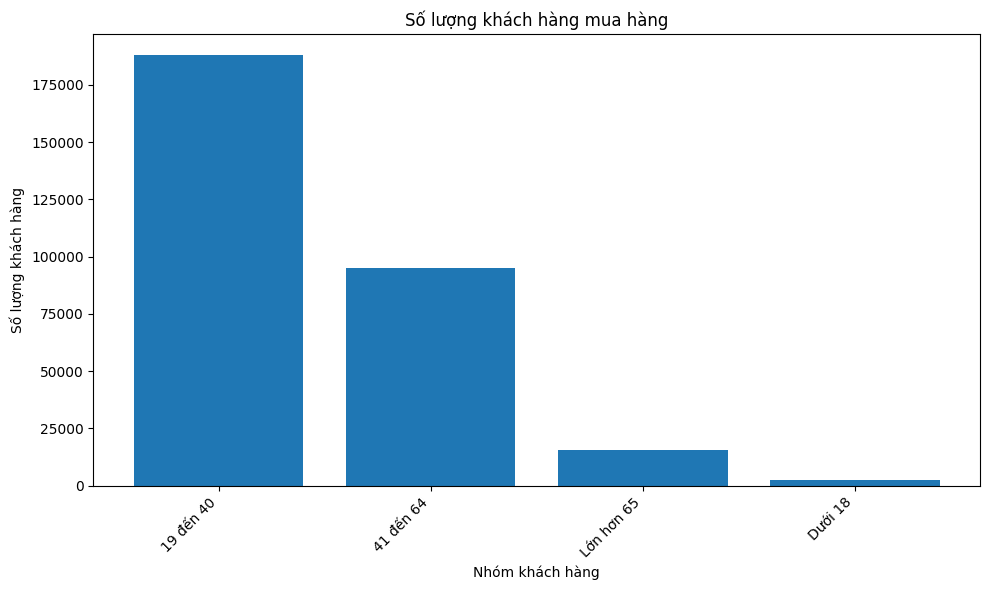

In [50]:
def phan_loai_giai_doan(age):
  """Phân loại độ tuổi thành 4 giai đoạn."""
  if 0 <= age <= 18:
    return "Dưới 18"
  elif 19 <= age <= 40:
    return "19 đến 40"
  elif 41 <= age <= 64:
    return "41 đến 64"
  elif age >= 65:
    return "Lớn hơn 65"

df_customers['Nhóm khách hàng'] = df_customers['Age'].apply(phan_loai_giai_doan)
# Đếm số lượng khách hàng trong mỗi nhóm
customer_counts = df_customers['Nhóm khách hàng'].value_counts()
# Lưu DataFrame đã được cập nhật vào file customers.csv
df_customers.to_csv('customers.csv', index=False)
# === Vẽ biểu đồ cột ===
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ
plt.bar(customer_counts.index, customer_counts.values)
plt.xlabel('Nhóm khách hàng')
plt.ylabel('Số lượng khách hàng')
plt.title('Số lượng khách hàng mua hàng')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x cho dễ nhìn
plt.tight_layout()  # Tự động điều chỉnh bố cục
plt.show()


Tổng chi tiêu của mỗi nhóm khách hàng:
Nhóm khách hàng
Cao niên         1.050890e+08
Thanh niên       1.077604e+09
Trung niên       6.245410e+08
Vị thành niên    1.200606e+08
Name: Total_Amount, dtype: float64


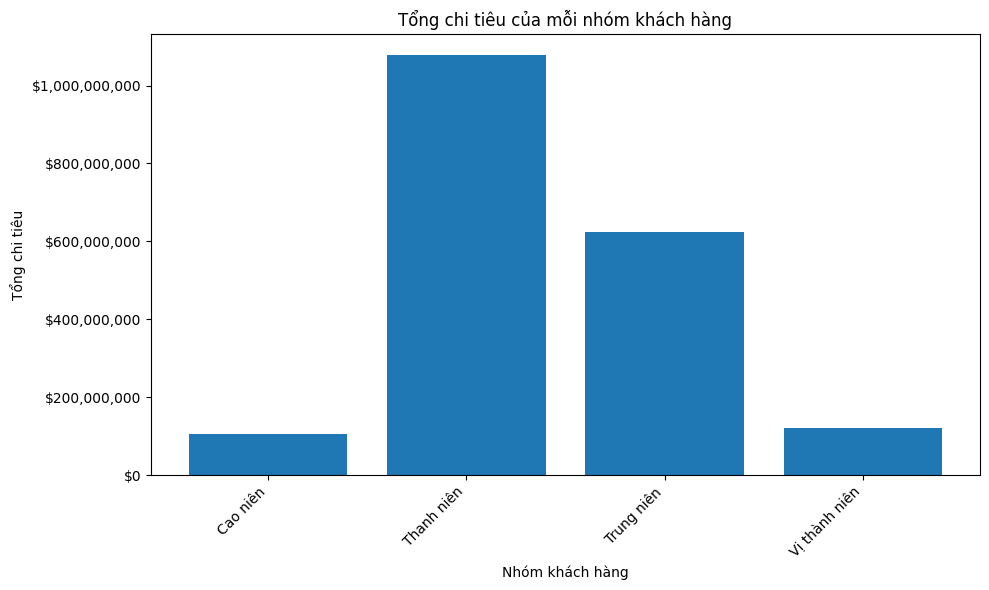

In [39]:
df = df.merge(df_customers[['Customer_ID', 'Nhóm khách hàng']], on='Customer_ID', how='left')
spending_by_group = df.groupby('Nhóm khách hàng')['Total_Amount'].sum()
print("Tổng chi tiêu của mỗi nhóm khách hàng:")
print(spending_by_group)

# === Vẽ biểu đồ tổng chi tiêu ===
plt.figure(figsize=(10, 6))
plt.bar(spending_by_group.index, spending_by_group.values)

# Format giá trị trục y
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

plt.xlabel('Nhóm khách hàng')
plt.ylabel('Tổng chi tiêu')
plt.title('Tổng chi tiêu của mỗi nhóm khách hàng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

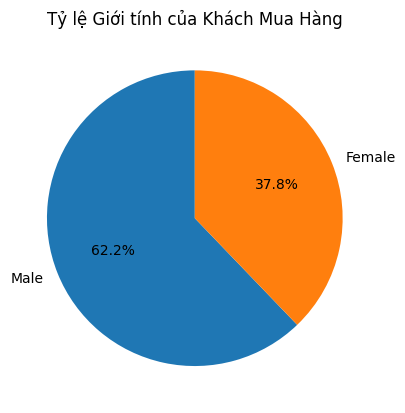

In [40]:
# === Đếm số lượng khách hàng theo giới tính ===
gender_counts = df_customers['Gender'].value_counts()

# === Vẽ biểu đồ tròn ===
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90) # Thêm autopct để hiển thị tỷ lệ phần trăm
plt.title('Tỷ lệ Giới tính của Khách Mua Hàng')
plt.show()

Country
USA          95024
UK           62869
Germany      52638
Australia    45131
Canada       45096
Name: count, dtype: int64


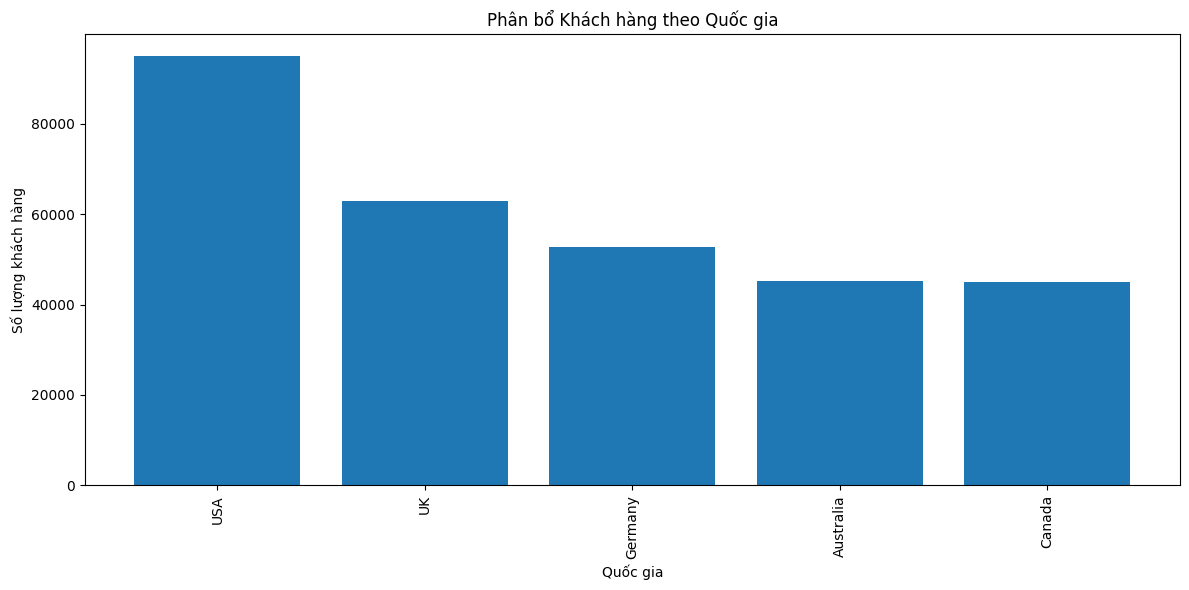

In [43]:
print(df_customers['Country'].value_counts())

# === Đếm số lượng khách hàng theo quốc gia ===
country_counts = df_customers['Country'].value_counts()

# === Vẽ biểu đồ cột ===
plt.figure(figsize=(12, 6))  # Điều chỉnh kích thước biểu đồ cho dễ nhìn
plt.bar(country_counts.index, country_counts.values)

# === Thêm thông tin cho biểu đồ ===
plt.title('Phân bổ Khách hàng theo Quốc gia')
plt.xlabel('Quốc gia')
plt.ylabel('Số lượng khách hàng')
plt.xticks(rotation=90)  # Xoay nhãn trục x 90 độ cho dễ đọc

# === Hiển thị biểu đồ ===
plt.tight_layout()  # Tự động điều chỉnh bố cục
plt.show()

In [51]:
df_customers.head(2)

,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Nhóm khách hàng
0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular,19 đến 40
1,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,19.0,Female,Low,Premium,19 đến 40


Customer_Segment
Regular    145864
New         90879
Premium     64070
Name: count, dtype: int64


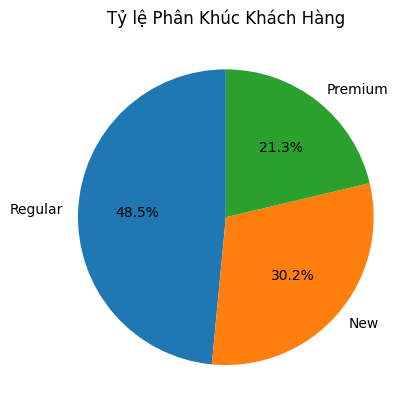

In [47]:
print(df_customers['Customer_Segment'].value_counts())

# === Đếm số lượng khách hàng theo phân khúc ===
segment_counts = df_customers['Customer_Segment'].value_counts()

# === Vẽ biểu đồ tròn ===
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ Phân Khúc Khách Hàng')
plt.show()

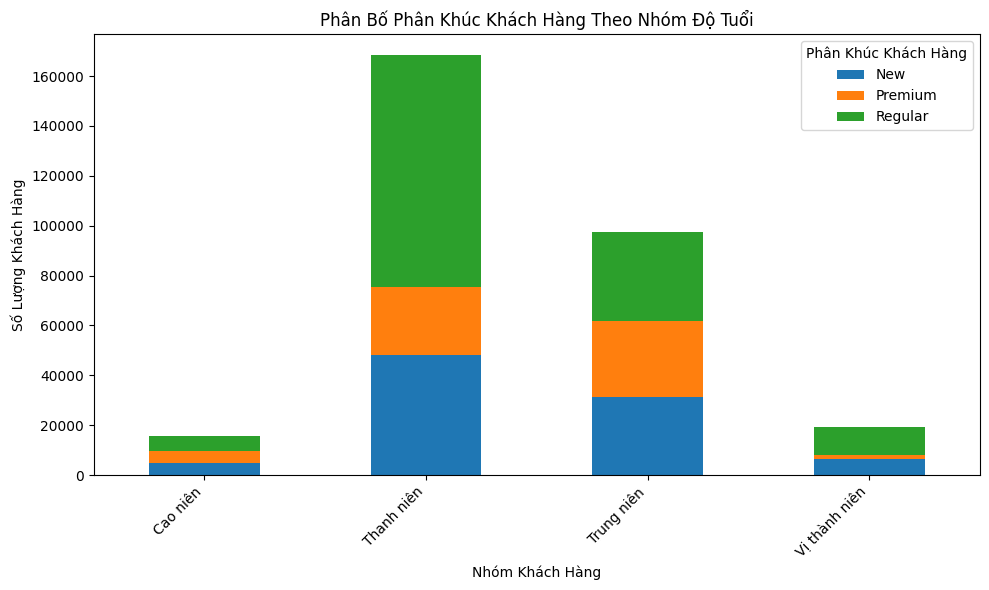

In [46]:
pivot_table = df_customers.pivot_table(values='Customer_ID',
                                       index='Nhóm khách hàng',
                                       columns='Customer_Segment',
                                       aggfunc='count',
                                       fill_value=0)  # Điền giá trị 0 cho ô trống

# === Vẽ biểu đồ cột chồng ===
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

# === Thêm thông tin cho biểu đồ ===
plt.title('Phân Bố Phân Khúc Khách Hàng Theo Nhóm Độ Tuổi')
plt.xlabel('Nhóm Khách Hàng')
plt.ylabel('Số Lượng Khách Hàng')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Phân Khúc Khách Hàng')

# === Hiển thị biểu đồ ===
plt.tight_layout()
plt.show()

# Mục mới